# Fruits - déploiement d'un modèle dans le cloud

## Installations 

In [1]:
! pip install --upgrade pip
! pip  install pyspark
# pip install tensorflow
!pip install intel-tensorflow #pour l'erreurDefault MaxPoolingOp only supports NHWC on device type CPU


Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from pyspark.sql import SparkSession
from pyspark import SparkConf

spark = SparkSession.builder.appName("Image_app").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/01/15 20:25:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
import boto3
import io
from PIL import Image
import requests
import time

import cv2
import numpy as np

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import to_categorical
from keras.applications.vgg16 import VGG16
from keras.layers import Dense
from keras.layers import Flatten
from keras import Model

2023-01-15 20:25:11.813643: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Chargement des informations à partir de S3 

In [5]:
# create an S3 client
s3 = boto3.client("s3")

In [6]:
response = s3.list_objects_v2(
    Bucket='bucket-p8-hh')

for content in response.get('Contents', []):
    print(content['Key'])

apple/r0_11.jpg
apple/r0_175.jpg
apple/r1_231.jpg
apple/r1_291.jpg
apple/r1_95.jpg
cabbage/r0_107.jpg
cabbage/r0_11.jpg
cabbage/r0_39.jpg
cabbage/r0_59.jpg
cabbage/r0_79.jpg
carrot/r0_131.jpg
carrot/r0_171.jpg
carrot/r0_31.jpg
carrot/r0_59.jpg
carrot/r0_91.jpg
pear/r0_19.jpg
pear/r0_3.jpg
pear/r0_39.jpg
pear/r0_67.jpg
pear/r0_95.jpg
sauvegarde
zucchini/r0_107.jpg
zucchini/r0_27.jpg
zucchini/r0_43.jpg
zucchini/r0_67.jpg
zucchini/r0_87.jpg


## Visualisation et analyse des fichiers 

image shape (527, 415, 3)
image shape (527, 418, 3)
image shape (527, 410, 3)
image shape (527, 421, 3)
image shape (524, 422, 3)
image shape (653, 187, 3)
image shape (631, 181, 3)
image shape (649, 216, 3)
image shape (661, 203, 3)
image shape (662, 186, 3)
image shape (1019, 292, 3)
image shape (1022, 278, 3)
image shape (1011, 282, 3)
image shape (1009, 288, 3)
image shape (1012, 297, 3)
image shape (432, 401, 3)
image shape (446, 400, 3)
image shape (405, 464, 3)
image shape (394, 425, 3)
image shape (409, 440, 3)
image shape (730, 738, 3)
image shape (730, 749, 3)
image shape (757, 786, 3)
image shape (768, 738, 3)
image shape (766, 785, 3)


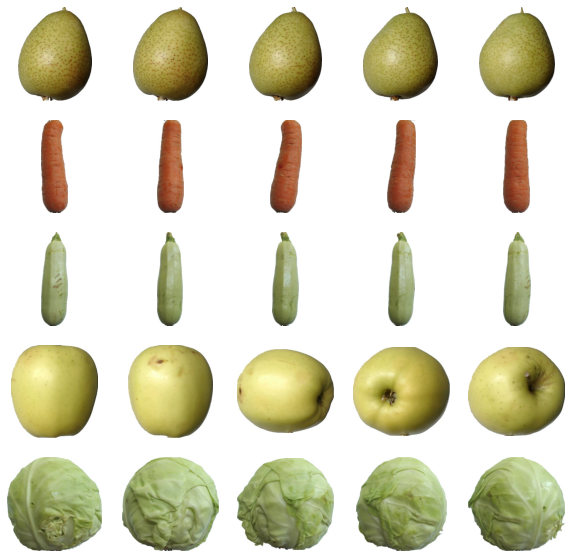

In [7]:

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.axis("off")
i = 1
for fruit in ['pear','carrot','zucchini','apple','cabbage']:
  
    response = s3.list_objects_v2(Bucket='bucket-p8-hh', Prefix=fruit)
    
    for content in response.get('Contents', []):
       
        file_path= content['Key'] #récupération du file_path et du nom de fichier
        # generate URL for the S3 object
        url = s3.generate_presigned_url(ClientMethod="get_object", Params={"Bucket": "bucket-p8-hh", "Key": file_path})
        # download the image using the presigned URL
        response = requests.get(url)
               
        # open the image with matplotlib & OpenCv
        image = Image.open(io.BytesIO(response.content))
        print('image shape' , np.shape(image))
        # display the image
        plt.axis("off")
        ax = plt.subplot(5, 5, i)
        plt.axis("off")
        plt.imshow(image)
        i = i +1 
        

## Création du dataframe image

In [8]:
columns = ['image', 'label']
vals = [(response.content,"drop")]


images_df = spark.createDataFrame(vals, columns)
for fruit in ['pear','carrot','zucchini','apple','cabbage']:
    #récuperer la liste des fichier dans le Bucket S3 
    response = s3.list_objects_v2(Bucket='bucket-p8-hh', Prefix=fruit)

    
    for content in response.get('Contents', []):
       
    
        file_path= content['Key']
        url = s3.generate_presigned_url(ClientMethod="get_object", Params={"Bucket": "bucket-p8-hh", "Key": file_path})
        response = requests.get(url)
        newRow = spark.createDataFrame([(response.content,fruit)], columns)
        appended = images_df.union(newRow)
        images_df=appended

In [9]:
images_df = images_df.filter(images_df.label!= 'drop')
images_df.show()
images_df.printSchema()



+--------------------+--------+
|               image|   label|
+--------------------+--------+
|[FF D8 FF E0 00 1...|    pear|
|[FF D8 FF E0 00 1...|    pear|
|[FF D8 FF E0 00 1...|    pear|
|[FF D8 FF E0 00 1...|    pear|
|[FF D8 FF E0 00 1...|    pear|
|[FF D8 FF E0 00 1...|  carrot|
|[FF D8 FF E0 00 1...|  carrot|
|[FF D8 FF E0 00 1...|  carrot|
|[FF D8 FF E0 00 1...|  carrot|
|[FF D8 FF E0 00 1...|  carrot|
|[FF D8 FF E0 00 1...|zucchini|
|[FF D8 FF E0 00 1...|zucchini|
|[FF D8 FF E0 00 1...|zucchini|
|[FF D8 FF E0 00 1...|zucchini|
|[FF D8 FF E0 00 1...|zucchini|
|[FF D8 FF E0 00 1...|   apple|
|[FF D8 FF E0 00 1...|   apple|
|[FF D8 FF E0 00 1...|   apple|
|[FF D8 FF E0 00 1...|   apple|
|[FF D8 FF E0 00 1...|   apple|
+--------------------+--------+
only showing top 20 rows

root
 |-- image: binary (nullable = true)
 |-- label: string (nullable = true)



## Préparation des données pour la classification 

### Séparation des données en ensembles d'entraînement et de test

In [10]:
train_df, test_df = images_df.randomSplit([0.8, 0.2], seed=22)

In [11]:
# Extraction des images au format np.array et des étiquettes des ensembles d'entraînement et de test

X_train = np.array([np.array(Image.open(io.BytesIO(x[0]))) for x in train_df.select('image').collect()])
y_train = np.array([x[0] for x in train_df.select('label').collect()])

X_test = np.array([np.array(Image.open(io.BytesIO(x[0]))) for x in test_df.select('image').collect()])
y_test = np.array([x[0] for x in test_df.select('label').collect()])



/tmp/ipykernel_12035/604373975.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train = np.array([np.array(Image.open(io.BytesIO(x[0]))) for x in train_df.select('image').collect()])
/tmp/ipykernel_12035/604373975.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_test = np.array([np.array(Image.open(io.BytesIO(x[0]))) for x in test_df.select('image').collect()])


In [12]:
print ('len',len(X_test))
print ('len',len(X_train))

len 6
len 19


### Redimensionnement des images pour qu'elles aient toutes la même taille

In [13]:
# on retient une taille assez petite 100 * 100 suffisante pour le test et qui consomme moins de ressources 

from keras.applications.vgg16 import preprocess_input

X_train = [cv2.resize(x, (100, 100)) for x in X_train]
X_train = np.array(X_train)


X_test = [cv2.resize(x, (100, 100)) for x in X_test]
X_test = np.array(X_test)


X_train = X_train.reshape((X_train.shape[0], 3, 100, 100))
X_test = X_test.reshape((X_test.shape[0], 3, 100, 100))


### Preprocess des images requis par Keras 

In [14]:
from keras.applications.vgg16 import preprocess_input

# Prétraitement des données d'entraînement
X_train = preprocess_input(X_train)

# Prétraitement des données de test
X_test = preprocess_input(X_test)


### transformation des labels en Int

In [15]:
from sklearn.preprocessing import LabelEncoder
# Création de l'objet LabelEncoder
encoder = LabelEncoder()
# Transformation des étiquettes en valeurs numériques
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)
#print ( y_test_encoded)

In [16]:
from tensorflow.keras.utils import to_categorical

# Transformation des 5 catégories en matrice binaire.
y_train_encoded = to_categorical(y_train_encoded, num_classes=5)
y_test_encoded = to_categorical(y_test_encoded, num_classes=5)


## Création du modele classification pour transfert learning : VGG16 Keras

In [17]:

from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
# import du modele sans les couches de classification par défaut
model = VGG16(include_top=False, input_shape=(3,100, 100)) 
# rajout des couches de classification  
flat1 = Flatten()(model.layers[-1].output) # a partir de la derniere couche 
class1 = Dense(1024, activation='relu')(flat1)
output = Dense(5, activation='softmax')(class1)
# dnouveau modéle 
model = Model(inputs=model.inputs, outputs=output)
# affichage
model.summary()

2023-01-15 20:25:44.889042: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-15 20:25:44.889357: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3, 100, 100)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 100, 100)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 100, 100)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 50, 50)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 50, 50)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 50, 50)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 128, 25, 25)       0     

### compilation et fit du modele

In [18]:

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [19]:

result = model.fit(X_train, y_train_encoded, epochs=5, validation_data=(X_test, y_test_encoded))

Epoch 1/5
1/1 [==============================] - 8s 8s/step - loss: 10.9389 - accuracy: 0.0526 - val_loss: 47.8821 - val_accuracy: 0.0000e+00
Epoch 2/5
1/1 [==============================] - 5s 5s/step - loss: 36.8280 - accuracy: 0.2632 - val_loss: 307.8225 - val_accuracy: 0.1667
Epoch 3/5
1/1 [==============================] - 7s 7s/step - loss: 345.6989 - accuracy: 0.2105 - val_loss: 7.2679 - val_accuracy: 0.3333
Epoch 4/5
1/1 [==============================] - 7s 7s/step - loss: 11.0877 - accuracy: 0.1579 - val_loss: 1.7158 - val_accuracy: 0.1667
Epoch 5/5
1/1 [==============================] - 7s 7s/step - loss: 1.6127 - accuracy: 0.2105 - val_loss: 1.9178 - val_accuracy: 0.0000e+00


### Récupération des résultats 

In [20]:
predict= model.predict(X_train)

1/1 [==============================] - 2s 2s/step


In [21]:
print ( predict) # le predict retourne pour chaque image le pourcentage de chance d'appartenir à une classe 

[[0.10998467 0.4053162  0.06233838 0.22809026 0.19427057]
 [0.10730058 0.41779914 0.05733242 0.22894797 0.18861994]
 [0.10710705 0.4154888  0.06051415 0.22375636 0.19313352]
 [0.11195963 0.35683203 0.11368829 0.19825117 0.21926889]
 [0.11341117 0.37064007 0.10972409 0.19557983 0.21064478]
 [0.10407484 0.42521957 0.05786934 0.22277687 0.19005933]
 [0.12758805 0.3426906  0.12017702 0.20120278 0.20834155]
 [0.12592442 0.3445375  0.12133761 0.19864297 0.20955753]
 [0.12334603 0.35287103 0.11790103 0.19750154 0.20838033]
 [0.12423582 0.35378456 0.11721598 0.1981511  0.2066125 ]
 [0.13770863 0.34220517 0.08135205 0.2434507  0.19528343]
 [0.12956445 0.35473573 0.07510072 0.24164398 0.19895498]
 [0.12159353 0.36198947 0.07576157 0.2343047  0.20635082]
 [0.1280909  0.35354522 0.08491851 0.22805038 0.20539498]
 [0.12264669 0.34718618 0.10954276 0.20589167 0.21473266]
 [0.11919817 0.3584131  0.10127532 0.2063253  0.21478814]
 [0.12167013 0.35649052 0.1048136  0.20561028 0.21141542]
 [0.11086587 0

## Extraction des features pour effectuer la réduction de dimension 

Charger le modèle VGG16 pré-entraîné en spécifiant que l'on ne souhaite pas inclure les couches de classification supérieures pour obtenir les features en sortie.

In [22]:
model_feature = VGG16(weights='imagenet', include_top=False, input_shape=(3,100,100))

model_feature.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])



In [23]:
model_feature.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 3, 100, 100)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 100, 100)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 100, 100)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 50, 50)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 50, 50)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 50, 50)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 128, 25, 25)       0     

In [24]:
features = model_feature.predict(X_train)

1/1 [==============================] - 1s 1s/step


In [25]:
print (features.shape)

(19, 512, 3, 3)


Les features (nombre d'images, nombre de features,dimensions des features) où chaque valeur représente l'activation d'un filtre dans l'une des couches de convolution du modèle VGG16 pour chaque image.

La première dimension (n_exemples) correspond au nombre d'images traités par la fonction predict(). Chaque exemple est représenté par un tenseur de forme (3, 3, 512) qui contient les caractéristiques extraites pour cet exemple.

Les dimensions 3, 3 et 512 correspondent aux dimensions de la sortie du dernier bloc de convolution de la partie du modèle VGG16 utilisée pour extraire les caractéristiques. 

Le nombre de canaux (512) est déterminé par le nombre de filtres utilisés dans le dernier bloc de convolution du modèle. C

Les dimensions 3 et 3 correspondent à la taille de la sortie du dernier bloc de convolution. Elles dépendent de la taille des images d'entrée et de la manière dont elles ont été traitées par le modèle. En général, plus la taille de l'image d'entrée est grande, plus la sortie du dernier bloc de convolution est grande.

## PCA sur les features 

### map sur les 2 premiers composants

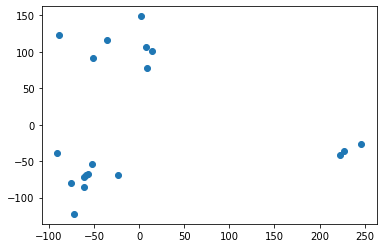

In [26]:
import numpy as np
from sklearn.decomposition import PCA
features_flattened = np.reshape(features, (19, 3*3*512))
pca = PCA(n_components=2)
pca_features = pca.fit_transform(features_flattened)
import matplotlib.pyplot as plt
plt.scatter(pca_features[:, 0], pca_features[:, 1])
plt.show()

### Eboulis PCA 

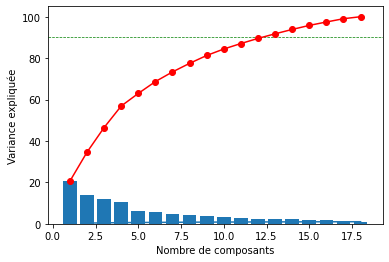

In [27]:
from pyspark.sql.types import StructType, StructField, FloatType, IntegerType
import matplotlib.pyplot as plt
from pyspark.sql.functions import lit

pcadf = spark.createDataFrame([], schema=StructType([
    StructField("N_composants", IntegerType(), nullable=True),
    StructField("Variance expliquée", FloatType(), nullable=True)]))


# Pour chaque nombre de composants de 1 à 512 (nombre de canaux de la sortie de VGG16)
for n_components in range(2, 19):
  # Instanciez un objet PCA avec le nombre de composants souhaité
  pca = PCA(n_components=n_components)
  
  # réduction de la dimensionnalité des caractéristiques en utilisant la PCA
  pca_features = pca.fit_transform(features_flattened)
  
  # Récupérez la variance expliquée par la PCA
  explained_variance = pca.explained_variance_ratio_.sum()
  newrow = spark.createDataFrame([(n_components, float(explained_variance))],schema=StructType([
    StructField("N_composants", IntegerType(), nullable=True),
    StructField("Variance expliquée", FloatType(), nullable=True) ]))
  append = pcadf.union(newrow)
  pcadf = append 

# Tracer un graphique en utilisant le module matplotlib

# Récupérez les valeurs de la colonne "n_components" et "explained_variance"

explained_variance = pcadf.select("Variance expliquée").collect()
n_components= pcadf.select("N_composants").collect()

# Tracer le graphique
plt.plot(n_components, explained_variance)
plt.xlabel("Nombre de composants")
plt.ylabel("Variance expliquée")
plt.axhline(y=90,linewidth=0.7, color='g', ls='--', label='90%')
scree_ = pca.explained_variance_ratio_ * 100

plt.bar(np.arange(len(scree_)) + 1, scree_,)
plt.plot(np.arange(len(scree_)) + 1,
scree_.cumsum(), color='r', marker='o', label="label")
plt.show()
# avec 12 features vs 512 on explique 90% de la variance. 

## Sauvegardes des features

In [29]:
print (type (pca_features))

<class 'numpy.ndarray'>


In [30]:
print (pca_features) 

[[ 2.46163345e+02 -2.65372696e+01 -5.51112404e+01 -2.38040714e+01
  -8.20224915e+01  6.34314156e+00  4.52708702e+01 -3.24124718e+01
   2.66256084e+01  2.04130096e+01 -3.34080086e+01 -3.93126369e+00
   5.18332596e+01  2.94780293e+01  3.30726242e+01 -4.73251305e+01
  -1.66857700e+01  1.05445004e+01]
 [ 2.26673798e+02 -3.57965279e+01 -1.35885973e+01 -5.19095480e-01
  -6.44856720e+01  6.02373171e+00  3.58439751e+01  7.77693462e+00
  -4.05663452e+01  1.15895903e+00  5.05097504e+01 -4.56630592e+01
  -4.43332481e+01 -2.37943020e+01 -4.46711006e+01  3.84750824e+01
   3.02362270e+01 -1.42163563e+01]
 [ 2.23125031e+02 -4.12410583e+01  1.54030170e+01 -4.51371880e+01
   1.42794617e+02 -5.56265450e+01 -9.65038376e+01  5.17426777e+00
   2.01691971e+01 -3.03016510e+01 -5.71471548e+00  3.41517982e+01
  -3.77122951e+00 -1.56384315e+01  1.56427646e+00  3.90119076e+00
  -4.31928396e+00  2.72989225e+00]
 [-8.88802643e+01  1.23170990e+02 -8.25202103e+01 -8.95003052e+01
  -3.97917442e+01 -1.40382507e+02 -6.

In [31]:
print (pca_features.shape)

(19, 18)


In [33]:
# Créer un objet 'Object' sur S3
pca_sauv = pca_features.tobytes()
s3.put_object(Bucket='bucket-p8-hh', Key='sauvegarde', Body=pca_sauv)

{'ResponseMetadata': {'RequestId': 'BED80TSBQZ6P53XP',
  'HostId': '4elQ1WHCJkQfX6pXdSXriJCdGYbhqINgBm6ODcGBIh36o8mrniCHrddUIYxZQw436nH9OA+ATjc=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': '4elQ1WHCJkQfX6pXdSXriJCdGYbhqINgBm6ODcGBIh36o8mrniCHrddUIYxZQw436nH9OA+ATjc=',
   'x-amz-request-id': 'BED80TSBQZ6P53XP',
   'date': 'Sun, 15 Jan 2023 20:26:28 GMT',
   'etag': '"97c6060803d51973f4fce4bef1d8b217"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"97c6060803d51973f4fce4bef1d8b217"'}

In [34]:
import io
from io import BytesIO

# Récupérez la liste des objets dans le bucket S3
objects = s3.list_objects(Bucket='bucket-p8-hh')

# Vérifiez si l'objet a bien été sauvegardé en vérifiant si son nom figure dans la liste des objets
if 'sauvegarde' in [obj['Key'] for obj in objects['Contents']]:
    print("L'objet a bien été sauvegardé sur S3")

L'objet a bien été sauvegardé sur S3


In [ ]:
# Récupérer  l'objet à partir de S3 
obj = s3.get_object(Bucket='bucket-p8-hh', Key='sauvegarde')

# Accédez à l'objet en tant que fichier binaire à l'aide de la clé 'Body' du dictionnaire
data = obj['Body'].read()

data_io = np.frombuffer((data)) #conversion du binaire vers le numpy array


In [37]:
lecture= np.ndarray((19,18),np.float32,data_io)

In [38]:
print (lecture)

[[ 2.46163345e+02 -2.65372696e+01 -5.51112404e+01 -2.38040714e+01
  -8.20224915e+01  6.34314156e+00  4.52708702e+01 -3.24124718e+01
   2.66256084e+01  2.04130096e+01 -3.34080086e+01 -3.93126369e+00
   5.18332596e+01  2.94780293e+01  3.30726242e+01 -4.73251305e+01
  -1.66857700e+01  1.05445004e+01]
 [ 2.26673798e+02 -3.57965279e+01 -1.35885973e+01 -5.19095480e-01
  -6.44856720e+01  6.02373171e+00  3.58439751e+01  7.77693462e+00
  -4.05663452e+01  1.15895903e+00  5.05097504e+01 -4.56630592e+01
  -4.43332481e+01 -2.37943020e+01 -4.46711006e+01  3.84750824e+01
   3.02362270e+01 -1.42163563e+01]
 [ 2.23125031e+02 -4.12410583e+01  1.54030170e+01 -4.51371880e+01
   1.42794617e+02 -5.56265450e+01 -9.65038376e+01  5.17426777e+00
   2.01691971e+01 -3.03016510e+01 -5.71471548e+00  3.41517982e+01
  -3.77122951e+00 -1.56384315e+01  1.56427646e+00  3.90119076e+00
  -4.31928396e+00  2.72989225e+00]
 [-8.88802643e+01  1.23170990e+02 -8.25202103e+01 -8.95003052e+01
  -3.97917442e+01 -1.40382507e+02 -6.